In [ ]:
!pip install opencv-python pip tensorflow keras

## Detection Using Image

In [12]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model

# Clone the repository containing the dataset
!git clone https://github.com/prajnasb/observations.git

# Define paths to the dataset directories
base_path = 'observations/experiements/data'
mask_path = os.path.join(base_path, 'with_mask')
no_mask_path = os.path.join(base_path, 'without_mask')

# Create train and validation directories
os.makedirs('dataset/train/with_mask', exist_ok=True)
os.makedirs('dataset/train/without_mask', exist_ok=True)
os.makedirs('dataset/validation/with_mask', exist_ok=True)
os.makedirs('dataset/validation/without_mask', exist_ok=True)

# Function to split the dataset into train and validation sets
def split_dataset(mask_dir, no_mask_dir, train_ratio=0.8):
    mask_images = os.listdir(mask_dir)
    no_mask_images = os.listdir(no_mask_dir)

    mask_train_count = int(train_ratio * len(mask_images))
    no_mask_train_count = int(train_ratio * len(no_mask_images))

    train_mask_images = mask_images[:mask_train_count]
    val_mask_images = mask_images[mask_train_count:]

    train_no_mask_images = no_mask_images[:no_mask_train_count]
    val_no_mask_images = no_mask_images[no_mask_train_count:]

    return train_mask_images, val_mask_images, train_no_mask_images, val_no_mask_images

# Split the dataset
train_mask_images, val_mask_images, train_no_mask_images, val_no_mask_images = split_dataset(mask_path, no_mask_path)

# Function to copy images to the respective directories
def copy_images(image_list, source_dir, dest_dir):
    for image in image_list:
        src_path = os.path.join(source_dir, image)
        dest_path = os.path.join(dest_dir, image)
        cv2.imwrite(dest_path, cv2.imread(src_path))

# Copy the images to the train and validation directories
copy_images(train_mask_images, mask_path, 'dataset/train/with_mask')
copy_images(val_mask_images, mask_path, 'dataset/validation/with_mask')
copy_images(train_no_mask_images, no_mask_path, 'dataset/train/without_mask')
copy_images(val_no_mask_images, no_mask_path, 'dataset/validation/without_mask')

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    'dataset/validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load pre-trained MobileNetV2 model without the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)  # 2 classes: Mask and No Mask

# Create full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10
)

# Save the model
model.save('mask_detection_model.h5')


Cloning into 'observations'...
remote: Enumerating objects: 1638, done.
remote: Total 1638 (delta 0), reused 0 (delta 0), pack-reused 1638
Receiving objects: 100% (1638/1638), 75.94 MiB | 34.18 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Updating files: 100% (3045/3045), done.
Found 1100 images belonging to 2 classes.
Found 276 images belonging to 2 classes.
Epoch 1/10
34/34 [==============================] - 249s 7s/step - loss: 2.2085 - accuracy: 0.9176 - val_loss: 8.1808 - val_accuracy: 0.9258
Epoch 2/10
34/34 [==============================] - 238s 7s/step - loss: 0.3381 - accuracy: 0.9625 - val_loss: 52.8874 - val_accuracy: 0.8164
Epoch 3/10
34/34 [==============================] - 234s 7s/step - loss: 0.1090 - accuracy: 0.9775 - val_loss: 10.0237 - val_accuracy: 0.9141
Epoch 4/10
34/34 [==============================] - 234s 7s/step - loss: 0.0191 - accuracy: 0.9972 - val_loss: 9.7079 - val_accuracy: 0.8906
Epoch 5/10
34/34 [==============================] - 229s 7s/step -

In [13]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow

# Load the trained model
model = load_model('mask_detection_model.h5')

# Labels for mask and no mask
class_labels = ['with_mask', 'without_mask']

# Function to detect face masks in an image
def detect_mask_in_image(image_path):
    # Load the image
    frame = cv2.imread(image_path)

    # Detect faces
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Process each detected face
    for (x, y, w, h) in faces:
        face_roi = frame[y:y + h, x:x + w]
        resized = cv2.resize(face_roi, (224, 224))
        normalized = resized / 255.0
        reshaped = np.reshape(normalized, (1, 224, 224, 3))
        result = model.predict(reshaped)

        label = np.argmax(result, axis=1)[0]
        label_text = class_labels[label]

        color = (0, 255, 0) if label_text == 'with_mask' else (0, 0, 255)

        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
        cv2.putText(frame, label_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # Display the image
    cv2_imshow(frame)


1/1 [==============================] - 2s 2s/step


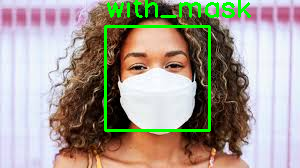

In [14]:
# Path to the image you want to process
image_path = 'mask.jpg'

# Detect mask in the image
detect_mask_in_image(image_path)

1/1 [==============================] - 0s 99ms/step


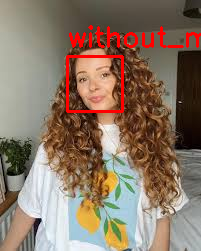

In [15]:
# Path to the image you want to process
image_path = 'no_mask.jpg'

# Detect mask in the image
detect_mask_in_image(image_path)